<center>
    <h3>Modelos Descriptivos y Predictivos II</h3>
    <h3>Grado en Ciencia de Datos</h3>
    <h3>Universitat Politècnica de València</h3>
    <h1>Trabajo Práctico</h1>
</center>

<a id='indice'></a>
## Índice
1. ### [Objetivos](#objetivos)
1. ### [Librerías python para clasificación](#librerias)
1. ### [Descripción de la tarea](#desc)
1. ### [Descripción del dataset](#dataset)
1. ### [Lectura de datos](#lectura)
1. ### [Problema propuesto](#problema)
1. ### [Evaluación](#evaluacion)

<a id='objetivos'></a>
### Objetivos formativos
- Diseñar un experimento de clasificación en una apliación práctica
- Analizar los resultados obtenidos en un problema de clasificación

<a id='librerias'></a>
### Librerías python para problemas de clasificación

Librerías de aprendizaje automático, entrada-salida, procesamiento de vectores (arrays), representación, visión por computador:

- NumPy: https://numpy.org/devdocs/contents.html
- SciPy: https://www.scipy.org/
- scikit-learn (utiliza las dos anteriores): https://scikit-learn.org/stable/
- Keras: https://keras.io
- Pandas: https://pandas.pydata.org/
- Matplotlib: https://matplotlib.org/
- OpenCV: https://pypi.org/project/opencv-python/

<a id='desc'></a>
### Descripción de la tarea

El propósito de este proyecto es **desarrollar un sistema de clasificación de manos humanas**. Este sistema debe funcionar con imágenes almacenadas en archivos JPG y su propósito es clasificar las imágenes en cuatro posibles categorías:

- Mano izquierda, vista posterior [LB]
- Mano izquierda, vista anterior [LF]
- Mano derecha, vista posterior [RB]
- Mano derecha, vista anterior [RF]

<a id='dataset'></a>
### Descripción del dataset

El primer paso para desarrollar este proyecto es disponer de una base de datos convenientemente anotada. Para ello se proporciona el dataset HANDS disponible en [http://www.prhlt.upv.es/~jandreu/HANDS-DB](http://www.prhlt.upv.es/~jandreu/HANDS-DB). 

Esta base de datos contiene una serie de imágenes de manos en formato JPG. El nombre de los ficheros sigue el patrón `NNNN_LL.JPG` donde:

- `NNNN` es un código numérico
- `LL` es la etiqueta de clase asociada a dicha imagen y será alguno de los valores definidos anteriormente (LB, LF, RB o RF).


<a id='lectura'></a>
### Lectura de datos

El siguiente script permite leer las distintas imágenes JPG y su 
etiqueta asociada:

Image: 0155_RB.jpg Label: RB


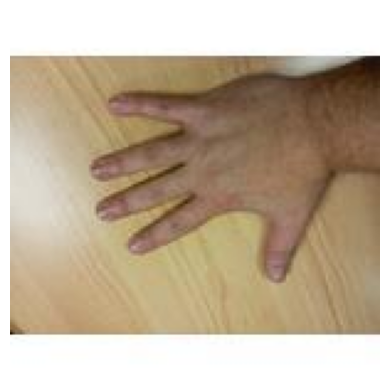

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

dataset_path = '/home/pablo/Desktop/tercero/mdp/trabajo/HANDS' # Cambiar si las  imágenes se encuentran en otra carpeta

for filename in os.listdir(dataset_path):
    # Obtener etiqueta
    img_label = filename[5:7]
    
    # Leer imagen
    img_path = os.path.join(dataset_path, filename)
    with open(img_path) as infile:
        img = cv2.imread(img_path)
            
    # Convertir imagen de BGR a RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Mostrar etiqueta
    print(f'Image: {filename} Label: {img_label}')

    # Mostrar imagen
    plt.imshow(img_rgb)
    plt.axis('off') 
    plt.show()
    
    break # Mostramos solo una imagen a modo de ejemplo

<a id='problema'></a>
### Problema propuesto

Se propone un problema de clasificación consiste en asignar una de las siguientes etiquetas de clase a una imagen dada. 

- LB: Vista posterior de la mano izquierda
- LF: Vista anterior de la mano izquierda
- RB: Vista posterior de la mano derecha
- RF: Vista anterior de la mano derecha


Puesto que la talla de las imágenes puede ser grande para
esta tarea es aconsejable reducir la dimensión de las mismas. Se
pueden probar diferentes estrategias como PCA o bien obtener una
representación en forma de *patches*. La librería
[scikit-learn](https://scikit-learn.org/) tiene alguna [función](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.extract_patches_2d.html)
para este propósito. Cada *patch* extraido puede utilizarse para
obtener alguna característica, como por ejemplo, la media de colores
del *patch*.

Se pide estudiar esta última propuesta para realizar una tarea de clasificación.

##### Extracción de características

La extracción o selección de característica en la tarea de
clasificación de imágenes de manos se puede abordar de diferentes
maneras. 

En este trabajo se propone un método basado en lo que se conoce como **Bag of Visual Words (BoVW)**, un concepto derivado del **Bag of Words (BoW)** utilizado en procesamiento de texto. Básicamente el proceso consiste en extraer pequeños trozos de imagen (*patches*) que sean discriminativos y representar posteriormente la imagen en función de estos *patches*. A continuación se explica con mayor detalle el método propuesto:

1. De cada imagen se extraen $50$ rectángulos de $5 \times 5$ (*patches*) de posiciones aleatorias. Esto permite capturar características locales de distintas partes de la imagen. Todos estos *patches* de cada imagen se van concatenando en un único array *numpy*.

1. Los valores de este array se normalizan para asegurarnos de que las características tengan la misma escala (media 0 y desviación estándar 1).


1. Sobre todos estos *patches* se realiza un proceso de *clustering* empleando para ello el algoritmo de *k-means*. En este caso definimos 81 *clusters*. Cada uno de estos clústers actúa como una **visual word**, representando patrones comunes en los *patches*. Dicho de otro modo, los 81 clústeres forman un vocabulario visual que describe las características típicas del conjunto de datos.

1. Tras este proceso cada imagen queda representada por un vector de índices, donde cada índice corresponde al clúster al que pertenece uno de sus *patches*. Esto convierte cada imagen en una secuencia de **visual words**, similar a cómo el modelo **Bag of Words** representa documentos de texto. Este es un número de características es mucho menor que utilizar la imagen en bruto, en cuyo caso quedaría representada por un vector de talla $150 \times 150 \times 3$ (número de píxeles por número de canales).

Finalmente, cabe destacar que para la realización del trabajo, cada alumno podrá emplear este mismo método, o cualquier otro que considere conveniente.

[MiniBatchKMeans] Reassigning 18 cluster centers.


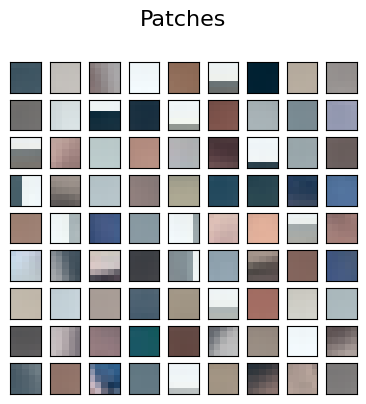

In [2]:
import cv2
import numpy as np
import os
from sklearn.feature_extraction import image
from sklearn.cluster import MiniBatchKMeans


dataset_path = '/home/pablo/Desktop/tercero/mdp/trabajo/HANDS'   # Cambiar por la carpeta en la que se encuentran las imágenes
 
jpgFiles = [fJPG for fJPG in os.listdir(dataset_path) if fJPG.endswith('.jpg')]
pSize = (5, 5)
bufferData = []
y = []

# Extraer 50 patches aleatorios de cada imagen
for filename in jpgFiles:
    img_path = os.path.join(dataset_path, filename)
    with open(img_path) as infile:
        # Obtener etiqueta
        img_label = filename[5:7] 
        y.append(img_label)
        # Leer imagen
        img = cv2.imread(img_path)
        # Convertir imagen de BGR a RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Extraer patches  
        patches = image.extract_patches_2d(img_rgb, pSize, max_patches=50, random_state=27) # shape = (50,5,5,3)
        patches = np.reshape(patches, (len(patches), -1)) # shape = (50,75)
        bufferData.append(patches)
        
# Normalizar patches
dataIm = np.concatenate(bufferData, axis=0) # shape = (1000,75)  50 patches x 200 imágenes = 1000 patches
dataIm = dataIm.astype(float)
dataIm -= np.mean(dataIm, axis=0)
dataIm /= np.std(dataIm, axis=0)

# Aplicar algoritmo de k-means para agrupar los patches en 81 clusters
kmeans = MiniBatchKMeans(n_clusters=81, random_state=27, verbose=True)
kmeans.partial_fit(dataIm)

# Obtener la etiqueta de cada patche (índice de cluster al que pertenece)
X = np.reshape(kmeans.labels_ , (len(jpgFiles),50)) # Indice de cluster de cada patch. shape = (200,50) 200 imágenes x 50 patches

# Representar visualmente los centroides de cada cluster
min_value = kmeans.cluster_centers_.min()
max_value = kmeans.cluster_centers_.max()
import matplotlib.pyplot as plt
plt.figure(figsize=(4.2, 4))
for i, patch in enumerate(kmeans.cluster_centers_):
    # plot centroids to have a visual view
    plt.subplot(9, 9, i + 1)
    patch = (patch - min_value) / (max_value - min_value)
    #patch = (patch - patch.min()) / (patch.max() - patch.min())
    plt.imshow(patch.reshape((5,5,3)), interpolation="nearest")
    plt.xticks(()); plt.yticks(())
plt.suptitle(
    "Patches",
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

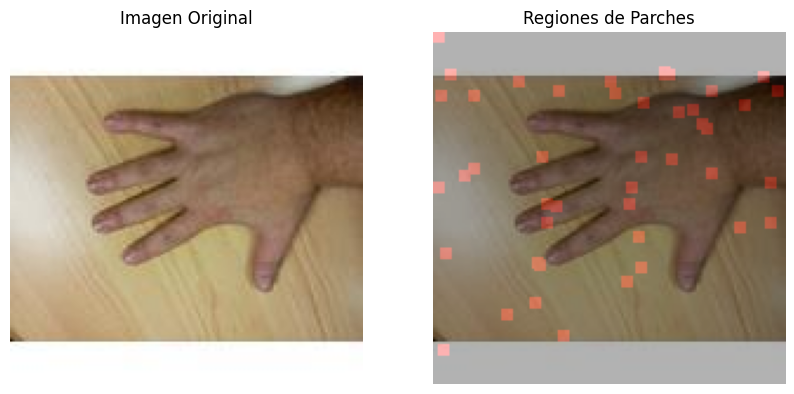

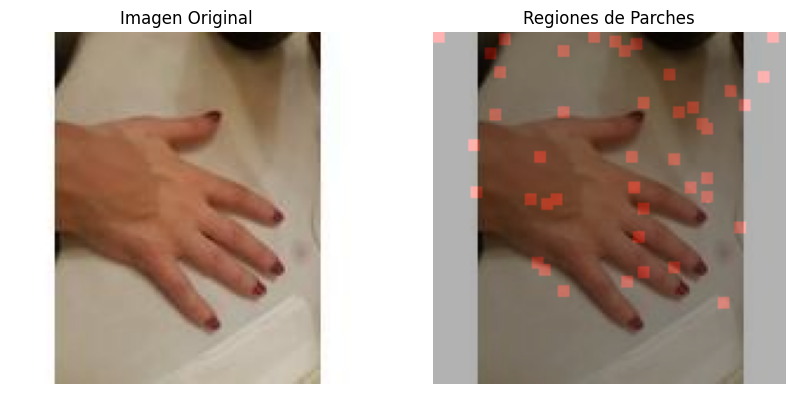

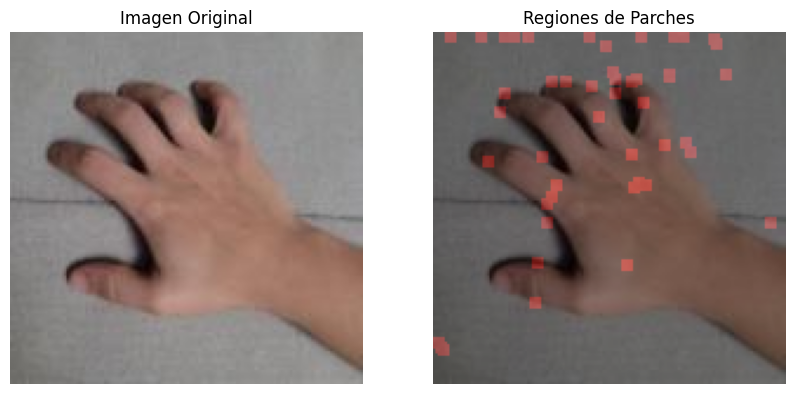

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d

def visualize_patches(image_path, patch_size=(50, 50), max_patches=10):
    # Cargar la imagen
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB para matplotlib

    # Extraer parches
    patches = extract_patches_2d(image, patch_size, max_patches=max_patches, random_state=27)

    # Crear una máscara para visualizar las áreas seleccionadas
    mask = np.zeros_like(image, dtype=np.uint8)
    for patch in patches:
        # Encontrar la ubicación del parche en la imagen original
        y, x = np.where(np.all(image == patch[0, 0], axis=-1))[:2]
        if len(x) > 0 and len(y) > 0:
            start_x, start_y = x[0], y[0]
            end_x, end_y = start_x + patch_size[1], start_y + patch_size[0]
            mask[start_y:end_y, start_x:end_x] = [255, 0, 0]  # Marcar en rojo

    # Superponer la máscara sobre la imagen original
    overlay = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    # Mostrar resultados
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Imagen Original")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Regiones de Parches")
    plt.imshow(overlay)
    plt.axis("off")

    plt.show()

dataset_path = '/home/pablo/Desktop/tercero/mdp/trabajo/HANDS'   # Cambiar por la carpeta en la que se encuentran las imágenes
 
jpgFiles = [fJPG for fJPG in os.listdir(dataset_path) if fJPG.endswith('.jpg')]

cont = 0
for filename in jpgFiles:
    img_path = os.path.join(dataset_path, filename)
    visualize_patches(img_path, patch_size=(5, 5), max_patches=50)
    cont += 1
    if cont == 3:
        break


El resultado de ejecutar el código anterior es una figura con 81 imágenes. Cada una de estas imágenes es una representación visual de los 81 centroides obtenidos con el algorimo *k-means*.

Una vez obtenemos el resultado, cada imagen se puede representar con un vector de talla 50. Por ejemplo, la imagen siguiente:

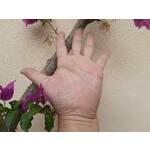

tendría una representación en términos de las etiquetas de los
clusters como: 

$[69, 36, 37, 63, 3, 79, 5, 4, 63, 42, 3, 63, 68, 76, 63, 44, 24, 63, 63, 3, 4, 36, 25, 23, 49,$
$3, 41, 3, 42, 37, 9, 37, 7, 37, 5, 5, 37, 3, 36, 32, 42, 3, 63, 25, 27, 36, 3, 63, 76, 42]$

y su etiqueta de clase sería **LF**. 

Por último basta ejecutar la siguiente instrucción para dejar los datos listos:

`X = np.reshape(kmeans.labels_ , (len(jpgFiles),50))`

Un vistazo a X:

In [4]:
X[0]

array([31, 80, 63,  1, 26, 30,  7,  3,  7, 70,  7, 70, 70, 61, 13, 80, 26,
       31, 58, 70,  7, 26,  9,  1, 30, 26, 31, 80, 31, 61, 69,  7,  3, 30,
       51, 80, 69, 18, 12,  7,  3, 63,  3,  7, 48, 30,  5, 30, 70, 80],
      dtype=int32)

<a id='evaluacion'></a>
### Evaluación

La evaluación de las prácticas (E5) se realizará como se describe a continuación:

1. La base de datos de entrenamiento puede descargarse de:
      [http://www.prhlt.upv.es/~jandreu/HANDS-DB](http://www.prhlt.upv.es/~jandreu/HANDS-DB). Se debe
      descargar la última versión.
      
1. Se debe preparar el mejor clasificador posible con cualquiera de las técnicas vistas en clase utilizando los datos de entrenamiento.

1. En una fecha concreta se enviará un correo a los alumnos informando de la disponibilidad de los datos de test. Estos estarán sin etiquetar.

1. Los alumnos deberán subir a una tarea de PoliformaT las etiquetas resultantes de clasificación de los datos de test. En dicha tarea se indicará la fecha tope de envio de resultados y el formato de envio. También deberá adjuntarse el script python que ha permitido obtener dicha clasificación. **El profesor debe ser capaz de generar esas mismas etiquetas ejecutando el código enviado.**

1. La nota de evaluación será función del resultado de clasificación obtenido sobre el conjunto de test.

1. Las etiquetas del conjunto de test se harán públicas tras concluir el periodo de envio de resultados.

## Resolución

In [6]:
import cv2
import numpy as np
import os
from sklearn.feature_extraction import image
from sklearn.cluster import MiniBatchKMeans
dataset_path = '/home/pablo/Desktop/tercero/mdp/trabajo/HANDS'   # Cambiar por la carpeta en la que se encuentran las imágenes
 
jpgFiles = [fJPG for fJPG in os.listdir(dataset_path) if fJPG.endswith('.jpg')]
y = [file.split('.')[0][-2:] for file in jpgFiles]
print('Comprobación:', all([x in ['RB', 'RF', 'LB', 'LF'] for x in y]))

Comprobación: True


Ya tenemos los labels

Ahora tenemos que obtener los datos de entrenamiento y validación, pero para obtener estos datos hay parámetros que podemos ajustar, y para no tener que ajustarlos de manera manual, vamos a crear una subclase de las clases base de sklearn para poder automatizar el ajuste de los parámetros con GridSearch.

In [8]:
import cv2
import numpy as np
import os
from sklearn.feature_extraction import image
from sklearn.cluster import MiniBatchKMeans

dataset_path = '/home/pablo/Desktop/tercero/mdp/trabajo/HANDS'   # Cambiar por la carpeta en la que se encuentran las imágenes
 
jpgFiles = [fJPG for fJPG in os.listdir(dataset_path) if fJPG.endswith('.jpg')]

bufferImages = []
y = []

# Extraer 50 patches aleatorios de cada imagen
for filename in jpgFiles:
    img_path = os.path.join(dataset_path, filename)
    label = filename.split('.')[0][-2:]
    y.append(label)
    with open(img_path) as infile:
        # Obtener etiqueta
        img_label = filename[5:7] 
        # Leer imagen
        img = cv2.imread(img_path)
        # Convertir imagen de BGR a RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        bufferImages.append(img_rgb)
print(len(bufferImages))
print('Comprobación:', all([x in ['RB', 'RF', 'LB', 'LF'] for x in y]))

200
Comprobación: True


Hay que tener en cuenta que las dimensiones de las imágenes no son homogéneas, hay imágenes de más resolución que otras por lo que `bufferImages` no es un cubo.

Trabajaremos sobre las imagenes en RGB y estas se las pasaremos al pipeline.

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPreprocessorBad(BaseEstimator, TransformerMixin):
    def __init__(self, patchSize=(5,5), nClusters = 81, max_patches=50):
        self.patchSize = patchSize
        self.nClusters = nClusters
        self.max_patches = max_patches

    def fit(self, X, y=None):
        return self
    
    def bovw(self, images, patchSize, nClusters, maxPatches):
        bufferData = []
        for i in images:
            patches = image.extract_patches_2d(i, patchSize, max_patches=maxPatches, random_state=27) # shape = (maxPatches,5,5,3)
            patches = np.reshape(patches, (len(patches), -1)) # shape = (maxPatches,75)
            bufferData.append(patches)
        dataIm = np.concatenate(bufferData, axis=0) # shape = (200*maxPatches,75)  n patches x 200 imágenes
        dataIm = dataIm.astype(float)
        dataIm -= np.mean(dataIm, axis=0)
        dataIm /= np.std(dataIm, axis=0)
        kmeans = MiniBatchKMeans(n_clusters=nClusters, random_state=27, verbose=False)
        kmeans.partial_fit(dataIm)

        X = np.reshape(kmeans.labels_ , (len(images),maxPatches)) # Indice de cluster de cada patch. shape = (200,maxPatches)
        resul = [np.bincount(row, minlength=nClusters) for row in X]
        resul = np.array(resul)
        return resul

    def transform(self, images):
        # Aplica tu función de preprocesamiento aquí
        # Por ejemplo:
        # return your_custom_function(X, param1=self.param1)
        return self.bovw(images, self.patchSize, self.nClusters, self.max_patches)  # Devuelve los datos preprocesados


In [7]:
p = CustomPreprocessorBad()
rep = p.transform(bufferImages)
print(rep[0])

[0 2 0 4 0 1 0 7 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 4 0 0 0 5 4 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 2 0 2 0 0 0 0 0 2 5 0 0 0
 0 0 0 0 0 0 5]


Ahora mismo con esta implementación, hay palabras visuales que son muy frecuentes en todas las palabras y en realidad no son muy relevantes para clasificar la imagen:

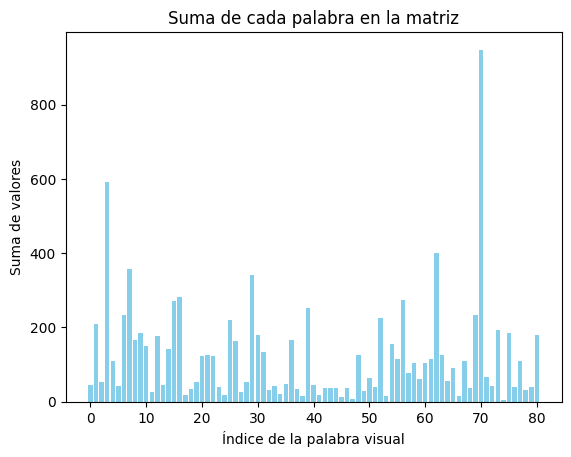

In [8]:
suma_columnas = np.sum(rep, axis=0)

plt.bar(range(len(suma_columnas)), suma_columnas, color='skyblue')

plt.xlabel('Índice de la palabra visual')
plt.ylabel('Suma de valores')
plt.title('Suma de cada palabra en la matriz')

plt.show()

Hay que cambiar la implementación para que tenga en cuenta la frecuencia.

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, patchSize=(5,5), nClusters = 81, max_patches=50):
        self.patchSize = patchSize
        self.nClusters = nClusters
        self.max_patches = max_patches

    def fit(self, X, y=None):
        return self
    
    def bovw(self, images, patchSize, nClusters, maxPatches):
        bufferData = []
        for i in images:
            patches = image.extract_patches_2d(i, patchSize, max_patches=maxPatches, random_state=27) # shape = (maxPatches,5,5,3)
            patches = np.reshape(patches, (len(patches), -1)) # shape = (maxPatches,75)
            bufferData.append(patches)
        dataIm = np.concatenate(bufferData, axis=0) # shape = (200*maxPatches,75)  n patches x 200 imágenes
        dataIm = dataIm.astype(float)
        dataIm -= np.mean(dataIm, axis=0)
        dataIm /= np.std(dataIm, axis=0)
        kmeans = MiniBatchKMeans(n_clusters=nClusters, random_state=27, verbose=False)
        kmeans.partial_fit(dataIm)

        X = np.reshape(kmeans.labels_ , (len(images),maxPatches)) # Indice de cluster de cada patch. shape = (200,maxPatches)
        print('El resultado original:',X[0])
        resul = [np.bincount(row, minlength=nClusters) for row in X]
        resul = np.array(resul)

        # Aquí vemos cuál es la frecuencia de cada una de las palabras
        contador_palabras = np.zeros((nClusters,))
        for p in range(nClusters):
            for i in resul[:,p]:
                if i > 0:
                    contador_palabras[p] += 1
        print(contador_palabras)
        return resul

    def transform(self, images):
        # Aplica tu función de preprocesamiento aquí
        # Por ejemplo:
        # return your_custom_function(X, param1=self.param1)
        return self.bovw(images, self.patchSize, self.nClusters, self.max_patches)  # Devuelve los datos preprocesados


In [10]:
p = CustomPreprocessor()
rep = p.transform(bufferImages)
print(rep[0])

El resultado original: [31 80 63  1 26 30  7  3  7 70  7 70 70 61 13 80 26 31 58 70  7 26  9  1
 30 26 31 80 31 61 69  7  3 30 51 80 69 18 12  7  3 63  3  7 48 30  5 30
 70 80]
[ 30.  63.  43. 158.  49.  42.  42. 109.  79.  95.  76.  27.  71.  45.
  46.  86.  80.  10.  35.  41.  55.  41.  52.  27.  19.  76.  87.  26.
  41.  75.  91.  51.  15.  27.  17.  13.  67.  35.   9.  71.  46.  12.
  12.  35.  31.  11.  29.   6.  56.  26.  39.  30.  86.   6.  60.  58.
  96.  30.  59.  59.  35.  49.  77.  68.  47.  54.   7.  49.  30.  98.
 155.  47.  33.  83.   4.  54.  39.  67.  28.  25.  82.]
[0 2 0 4 0 1 0 7 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 4 0 0 0 5 4 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 2 0 2 0 0 0 0 0 2 5 0 0 0
 0 0 0 0 0 0 5]


Aquí vemos que la palabra 3 y la palabra 7 son muy abundantes, por lo que habrá que tenerlo en cuenta.

In [1]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, patchSize=(5,5), nClusters = 81, max_patches=50):
        self.patchSize = patchSize
        self.nClusters = nClusters
        self.max_patches = max_patches

    def fit(self, X, y=None):
        return self
    
    def bovw(self, images, patchSize, nClusters, maxPatches):
        bufferData = []
        for i in images:
            patches = image.extract_patches_2d(i, patchSize, max_patches=maxPatches, random_state=27) # shape = (maxPatches,5,5,3)
            patches = np.reshape(patches, (len(patches), -1)) # shape = (maxPatches,75)
            bufferData.append(patches)
        dataIm = np.concatenate(bufferData, axis=0) # shape = (200*maxPatches,75)  n patches x 200 imágenes
        dataIm = dataIm.astype(float)
        dataIm -= np.mean(dataIm, axis=0)
        dataIm /= np.std(dataIm, axis=0)
        kmeans = MiniBatchKMeans(n_clusters=nClusters, random_state=27, verbose=False)
        kmeans.partial_fit(dataIm)

        X = np.reshape(kmeans.labels_ , (len(images),maxPatches)) # Indice de cluster de cada patch. shape = (200,maxPatches)
        cont = [np.bincount(row, minlength=nClusters) for row in X]
        resul = np.array(cont, dtype='float')

        # Aquí vemos cuál es la frecuencia de cada una de las palabras
        contador_palabras = np.zeros((nClusters,))
        for p in range(nClusters):
            for i in resul[:,p]:
                if i > 0:
                    contador_palabras[p] += 1
        for p in range(nClusters):
            for imagen in resul:
                imagen[p] = imagen[p] * np.log(len(images)/(contador_palabras[p]+0.001)) # Actualizamos el valor por el logaritmo del cociente entre N y el número de imágenes en las que aparece esa palabra
        return resul

    def transform(self, images):
        # Aplica tu función de preprocesamiento aquí
        # Por ejemplo:
        # return your_custom_function(X, param1=self.param1)
        return self.bovw(images, self.patchSize, self.nClusters, self.max_patches)  # Devuelve los datos preprocesados


In [83]:
p = CustomPreprocessor()
rep = p.transform(bufferImages)
print(rep[0])

[0.         2.31033353 0.         0.94286402 0.         1.56062394
 0.         4.24872217 0.         0.74442995 0.         0.
 1.03562341 1.49163265 0.         0.         0.         0.
 1.74294073 0.         0.         0.         0.         0.
 0.         0.         3.32959101 0.         0.         0.
 3.93723436 5.4658885  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.27294782 0.         0.         1.89708665 0.         0.
 0.         0.         0.         0.         1.22076297 0.
 0.         2.81295332 0.         2.15758991 0.         0.
 0.         0.         0.         1.42667937 1.27442899 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         4.45792962]


### Pruebas con diferentes modelos

In [84]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(bufferImages, y, test_size=0.2, shuffle=True, random_state=27)

cp = CustomPreprocessor()
knn = KNeighborsClassifier()

pipe = Pipeline(steps=[("preprocessor", cp), ("knn", knn)])

g = {'preprocessor__patchSize': [(5,5), (4,4)],  'preprocessor__max_patches': range(30, 51, 10), 'preprocessor__nClusters': range(120, 161, 10)
    ,'knn__metric': ['l2'], 'knn__weights': ['uniform', 'distance'], 'knn__n_neighbors': range(7, 9, 1)}

gs = GridSearchCV(pipe, g, scoring='accuracy', cv = 4, refit=True)

In [14]:
ent = gs.fit(X_train, y_train)
acc = ent.score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {gs.best_params_}')

Precisión: 30.0% con {'knn__metric': 'l2', 'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'preprocessor__max_patches': 50, 'preprocessor__nClusters': 130, 'preprocessor__patchSize': (4, 4)}


In [15]:
cp = CustomPreprocessor()
knn = KNeighborsClassifier()

pipe = Pipeline(steps=[("preprocessor", cp), ("knn", knn)])

g = {'preprocessor__patchSize': [(5,5), (4,4)],  'preprocessor__max_patches': range(40, 51, 10), 'preprocessor__nClusters': range(120, 161, 10)
    ,'knn__metric': ['l2'], 'knn__weights': ['uniform', 'distance'], 'knn__n_neighbors': range(8, 13, 2)}

gs = GridSearchCV(pipe, g, scoring='accuracy', cv = 4, refit=True)

ent = gs.fit(X_train, y_train)
acc = ent.score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {gs.best_params_}')

Precisión: 35.0% con {'knn__metric': 'l2', 'knn__n_neighbors': 8, 'knn__weights': 'uniform', 'preprocessor__max_patches': 50, 'preprocessor__nClusters': 130, 'preprocessor__patchSize': (4, 4)}


In [85]:
cp = CustomPreprocessor()
dt = DecisionTreeClassifier()

pipe = Pipeline(steps=[("preprocessor", cp), ("dt", dt)])

g = {'preprocessor__patchSize': [(5,5)],  'preprocessor__max_patches': range(40, 51, 10), 'preprocessor__nClusters': range(120, 131, 10)
    ,'dt__criterion': ['gini', 'log_loss', 'entropy']}

gs = GridSearchCV(pipe, g, scoring='accuracy', cv = 4, refit=True)

ent = gs.fit(X_train, y_train)
acc = ent.score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {gs.best_params_}')

Precisión: 22.5% con {'dt__criterion': 'gini', 'preprocessor__max_patches': 50, 'preprocessor__nClusters': 120, 'preprocessor__patchSize': (5, 5)}


### Pruebas MLP

In [16]:
import tensorflow as tf

2024-11-18 08:13:46.811038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731914026.854484    3945 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731914026.867976    3945 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 08:13:46.975414: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Vamos a usar la GPU ya que tensorflow usa la GPU por defecto si está disponible. 

`If a TensorFlow operation has both CPU and GPU implementations, by default, the GPU device is prioritized when the operation is assigned. For example, tf.matmul has both CPU and GPU kernels and on a system with devices CPU:0 and GPU:0, the GPU:0 device is selected to run tf.matmul unless you explicitly request to run it on another device. If a TensorFlow operation has no corresponding GPU implementation, then the operation falls back to the CPU device. For example, since tf.cast only has a CPU kernel, on a system with devices CPU:0 and GPU:0, the CPU:0 device is selected to run tf.cast, even if requested to run on the GPU:0 device.` [https://www.tensorflow.org/guide/gpu]

Vamos a crear otro paso del pipeline que sea un MLP, como voy a usar tensorlow tenemos que hacer un wrapper con sklearn.

In [18]:
from sklearn.base import ClassifierMixin
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical



class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=50, batch_size=32, verbose=1, model=None):
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = model
        self.classes_ = None # Necesario para el pipeline
        self.label_encoder = LabelEncoder()
        
    def fit(self, X, y):
        y_l = self.label_encoder.fit_transform(y)  # Codificar etiquetas
        self.classes_ = np.unique(y)
        callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=3)
        y_one_hot_encoding = to_categorical(y_l) # para usarlo en keras hay que pasarlo a one hot encoding
        # print('fit')
        # print(y)
        # print(y_l)
        # print(y_one_hot_encoding)
        h = self.model.fit(X, y_one_hot_encoding, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose, callbacks=[callback])
        return h

    def predict(self, X): # se llama con scoring='accuracy'
        index = np.argmax(self.model.predict(X), axis=-1)
        pred = self.classes_[index]
        return pred
    
    def score(self, X, y): # se llama con scoring=None
        y_l = self.label_encoder.fit_transform(y)  # Codificar etiquetas
        y_one_hot_encoding = to_categorical(y_l)
        # print('scoring')
        # print(y)
        # print(y_l)
        # print(y_one_hot_encoding)
        _, accuracy = self.model.evaluate(X, y_one_hot_encoding, verbose=self.verbose)
        print('el accuracy es:', accuracy)
        return accuracy

El problema aquí es que sklearn quiere las `y` como un vector de una sola columna y keras lo quiere con one hot encoding.

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam, SGD

In [20]:
y = np.array(y) # y lo convertimos a array de np para poder usarlo mejor
X_train, X_test, y_train, y_test = train_test_split(bufferImages, y, test_size=0.15, shuffle=True, random_state=27)

In [21]:
def build_mlp(optim): # Input dim en principio no es necesario
    model = Sequential()
    model.add(Input(shape=(80,)))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer = optim, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [22]:
sgd = SGD(learning_rate=0.01, momentum=0.9)
model = build_mlp(sgd)

mlp = CustomKerasClassifier(model=model)
cp = CustomPreprocessor()

pipe = Pipeline(steps=[("preprocessor", cp), ("mlp", mlp)])

g = {'preprocessor__patchSize': [(5, 5)],  'preprocessor__max_patches': range(5, 10, 2), 'preprocessor__nClusters': [80], # este debe coincidir con la capa input del MLP
     'mlp__epochs':[200], 'mlp__batch_size':[8], 'mlp__verbose': [1]}

gs = GridSearchCV(pipe, g, cv = 4, refit=True, scoring='accuracy')

I0000 00:00:1731914029.033950    3945 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5683 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [23]:
history = gs.fit(X_train, y_train)

Epoch 1/200


/home/pablo/Desktop/tercero/mdp/trabajo/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1731914030.137168    6592 service.cc:148] XLA service 0x7c337c003060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731914030.137286    6592 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-18 08:13:50.156912: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731914030.202178    6592 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3125 - loss: 1.2898

I0000 00:00:1731914030.908633    6592 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2520 - loss: 1.4883
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.3288 - loss: 1.3271
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.4770 - loss: 1.1855
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.5106 - loss: 1.0669
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.5261 - loss: 1.0362
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.5693 - loss: 0.9157
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.7530 - loss: 0.7553
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.6875 - loss: 0.7547
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - accuracy: 0.8018 - loss: 0.5931
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.8410 - loss: 0.5355
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.9254 - loss: 0.3914
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step 

In [24]:
history.best_score_

np.float64(0.23034330011074197)

In [25]:
history.best_params_

{'mlp__batch_size': 8,
 'mlp__epochs': 200,
 'mlp__verbose': 1,
 'preprocessor__max_patches': 5,
 'preprocessor__nClusters': 80,
 'preprocessor__patchSize': (5, 5)}

In [26]:
import pandas as pd
pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.806160      0.412463         0.406864        0.127947   
2       1.714432      0.297684         0.280247        0.006764   
1       1.586797      0.257706         0.279215        0.001737   

   param_mlp__batch_size  param_mlp__epochs  param_mlp__verbose  \
0                      8                200                   1   
2                      8                200                   1   
1                      8                200                   1   

   param_preprocessor__max_patches  param_preprocessor__nClusters  \
0                                5                             80   
2                                9                             80   
1                                7                             80   

  param_preprocessor__patchSize  \
0                        (5, 5)   
2                        (5, 5)   
1                        (5, 5)   

                                              params  split0_test_score  \
0  {'mlp__batch_size': 8, 'mlp__epochs': 200, 'ml...           0.209302   
2  {'mlp__batch_size': 8, 'mlp__epochs': 200, 'ml...           0.093023   
1  {'mlp__batch_size': 8, 'mlp__epochs': 200, 'ml...           0.302326   

   split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
0           0.093023           0.214286           0.404762         0.230343   
2           0.348837           0.238095           0.214286         0.223560   
1           0.116279           0.214286           0.214286         0.211794   

   std_test_score  rank_test_score  
0        0.111780                1  
2        0.090873                2  
1        0.065825                3

In [27]:
accuracy = gs.score(X_test, y_test)
print(f"Accuracy en test: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
Accuracy en test: 0.2


Vamos a ver si sale sin el gridSearch

In [64]:
l = LabelEncoder()
y_l  = l.fit_transform(y)
y_ohe = to_categorical(y_l)
cp = CustomPreprocessor(nClusters=3000, max_patches=50, patchSize=(5,5))
X = cp.transform(bufferImages)
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.15, shuffle=True, random_state=27)


In [65]:
from tensorflow.keras.layers import Dropout

In [74]:
sgd=SGD(learning_rate=0.01, momentum=0.9)

model = Sequential()
model.add(Input(shape=(3000,)))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer = sgd, loss='categorical_crossentropy',
                metrics=['accuracy'])

In [75]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)

In [76]:
model.fit(X_train, y_train, epochs=200, batch_size=4, callbacks=[callback], validation_data=(X_test, y_test))

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.2073 - loss: 1.4172 - val_accuracy: 0.2333 - val_loss: 1.4871
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2418 - loss: 1.4490 - val_accuracy: 0.1667 - val_loss: 1.4428
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2606 - loss: 1.4217 - val_accuracy: 0.2000 - val_loss: 1.4432
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2866 - loss: 1.4217 - val_accuracy: 0.2000 - val_loss: 1.4264
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2731 - loss: 1.4273 - val_accuracy: 0.2333 - val_loss: 1.4056
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2649 - loss: 1.3648 - val_accuracy: 0.1667 - val_loss: 1.4178
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4076 - loss: 1.3377 - val_accuracy: 0.3000 - val_loss: 1.3750
Epoch 8/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3573 - loss: 1.3336 - val_accuracy: 0.2333 - 

In [77]:
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1667 - loss: 1.4999


[1.499900460243225, 0.1666666716337204]

## SVM

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(bufferImages, y, test_size=0.2, shuffle=True, random_state=27)

cp = CustomPreprocessor()
svm = SVC()
pipe = Pipeline(steps=[("preprocessor", cp), ("svm", svm)])

g = {'preprocessor__patchSize': [(5,5), (10,10)],  'preprocessor__max_patches': [30, 50, 80], 'preprocessor__nClusters': [81, 160, 300],
     'svm__C': [0.01, 1, 10], 'svm__kernel': ['rbf', 'linear', 'sigmoid']}

gs = GridSearchCV(pipe, g, scoring='accuracy', cv = 4, refit=True, verbose=10)

In [14]:
ent = gs.fit(X_train, y_train)
acc = ent.score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {gs.best_params_}')

Fitting 4 folds for each of 162 candidates, totalling 648 fits
[CV 1/4; 1/162] START preprocessor__max_patches=30, preprocessor__nClusters=81, preprocessor__patchSize=(5, 5), svm__C=0.01, svm__kernel=rbf
[CV 1/4; 1/162] END preprocessor__max_patches=30, preprocessor__nClusters=81, preprocessor__patchSize=(5, 5), svm__C=0.01, svm__kernel=rbf;, score=0.250 total time=   0.2s
[CV 2/4; 1/162] START preprocessor__max_patches=30, preprocessor__nClusters=81, preprocessor__patchSize=(5, 5), svm__C=0.01, svm__kernel=rbf
[CV 2/4; 1/162] END preprocessor__max_patches=30, preprocessor__nClusters=81, preprocessor__patchSize=(5, 5), svm__C=0.01, svm__kernel=rbf;, score=0.250 total time=   0.2s
[CV 3/4; 1/162] START preprocessor__max_patches=30, preprocessor__nClusters=81, preprocessor__patchSize=(5, 5), svm__C=0.01, svm__kernel=rbf
[CV 3/4; 1/162] END preprocessor__max_patches=30, preprocessor__nClusters=81, preprocessor__patchSize=(5, 5), svm__C=0.01, svm__kernel=rbf;, score=0.250 total time=   0.2

Otro desastre

## SVM + PCA

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, patchSize=(5,5), nClusters = 81, max_patches=50):
        self.patchSize = patchSize
        self.nClusters = nClusters
        self.max_patches = max_patches

    def fit(self, X, y=None):
        return self
    
    def bovw(self, images, patchSize, nClusters, maxPatches):
        bufferData = []
        for i in images:
            patches = image.extract_patches_2d(i, patchSize, max_patches=maxPatches, random_state=27) # shape = (maxPatches,5,5,3)
            patches = np.reshape(patches, (len(patches), -1)) # shape = (maxPatches,75)
            bufferData.append(patches)
        dataIm = np.concatenate(bufferData, axis=0) # shape = (200*maxPatches,75)  n patches x 200 imágenes
        dataIm = dataIm.astype(float)
        dataIm -= np.mean(dataIm, axis=0)
        dataIm /= np.std(dataIm, axis=0)
        kmeans = MiniBatchKMeans(n_clusters=nClusters, random_state=27, verbose=False)
        kmeans.partial_fit(dataIm)

        X = np.reshape(kmeans.labels_ , (len(images),maxPatches)) # Indice de cluster de cada patch. shape = (200,maxPatches)
        cont = [np.bincount(row, minlength=nClusters) for row in X]
        resul = np.array(cont, dtype='float')

        # Aquí vemos cuál es la frecuencia de cada una de las palabras
        contador_palabras = np.zeros((nClusters,))
        for p in range(nClusters):
            for i in resul[:,p]:
                if i > 0:
                    contador_palabras[p] += 1
        for p in range(nClusters):
            for imagen in resul:
                imagen[p] = imagen[p] * np.log(len(images)/(contador_palabras[p]+0.001)) # Actualizamos el valor por el logaritmo del cociente entre N y el número de imágenes en las que aparece esa palabra
        return resul

    def transform(self, images):
        # Aplica tu función de preprocesamiento aquí
        # Por ejemplo:
        # return your_custom_function(X, param1=self.param1)
        return self.bovw(images, self.patchSize, self.nClusters, self.max_patches)  # Devuelve los datos preprocesados


In [6]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# encoder = LabelEncoder()
# y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=27)


svm = SVC()
pca = PCA()
pipe = Pipeline(steps=[("pca", pca), ("svm", svm)])

g = {
     'svm__C': [1], 'svm__kernel': ['rbf', 'linear'], 'pca__n_components':[30]}

gs = GridSearchCV(pipe, g, scoring='accuracy', cv = 4, refit=True, verbose=10)

In [7]:
ent = gs.fit(X_train, y_train)
acc = ent.score(X_test, y_test)
print(f'Precisión: {acc:.1%} con {gs.best_params_}')

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV 1/4; 1/2] START pca__n_components=30, svm__C=1, svm__kernel=rbf.............
[CV 1/4; 1/2] END pca__n_components=30, svm__C=1, svm__kernel=rbf;, score=0.250 total time=   0.0s
[CV 2/4; 1/2] START pca__n_components=30, svm__C=1, svm__kernel=rbf.............
[CV 2/4; 1/2] END pca__n_components=30, svm__C=1, svm__kernel=rbf;, score=0.200 total time=   0.0s
[CV 3/4; 1/2] START pca__n_components=30, svm__C=1, svm__kernel=rbf.............
[CV 3/4; 1/2] END pca__n_components=30, svm__C=1, svm__kernel=rbf;, score=0.200 total time=   0.0s
[CV 4/4; 1/2] START pca__n_components=30, svm__C=1, svm__kernel=rbf.............
[CV 4/4; 1/2] END pca__n_components=30, svm__C=1, svm__kernel=rbf;, score=0.350 total time=   0.0s
[CV 1/4; 2/2] START pca__n_components=30, svm__C=1, svm__kernel=linear..........
[CV 1/4; 2/2] END pca__n_components=30, svm__C=1, svm__kernel=linear;, score=0.250 total time=   3.4s
[CV 2/4; 2/2] START pca__n_components=

## Sin usar patches

No consigo que los modelos aprendan con patches, por lo que lo mejor será probar con un preprocesado diferente y volver a probar con estos modelos.

### Preprocesado

Vamos a dejar todas las imágenes del mismo tamaño y luego aplicarle un preprocesado.

In [3]:
def reduce_noise_non_local_means(image, h=4):
    """
    Aplica el denoising de medias no locales (Non-Local Means) para reducir el ruido.
    
    Args:
        image (numpy.ndarray): Imagen de entrada.
        h (float): Parámetro de suavizado. Cuanto mayor sea h, más fuerte será la eliminación de ruido.
    
    Returns:
        image_denoised (numpy.ndarray): Imagen con ruido reducido.
    """
    image_denoised = cv2.fastNlMeansDenoising(image, None, h, 7, 21)
    return image_denoised

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0155_RB.jpg


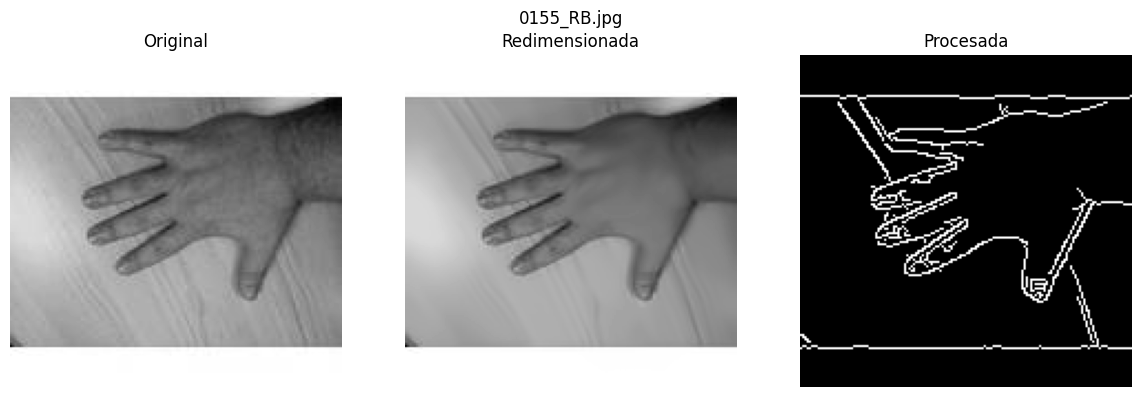

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0129_RB.jpg


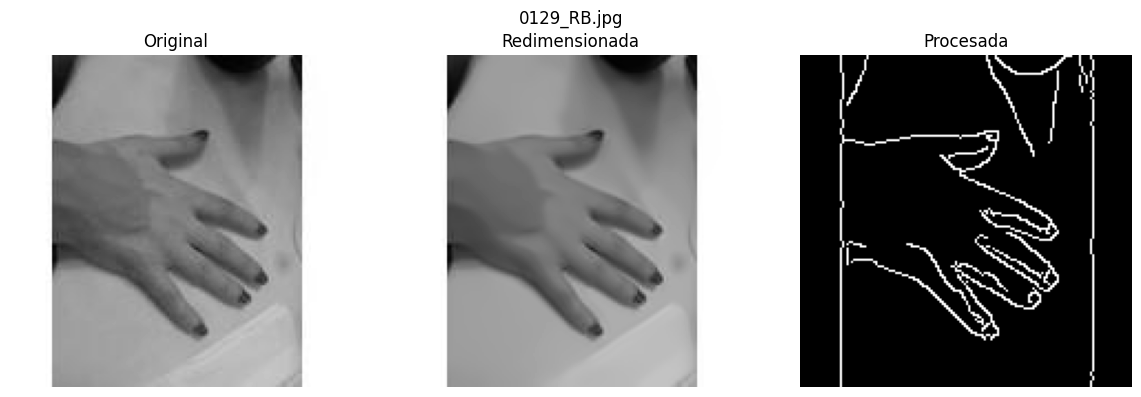

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0074_RB.jpg


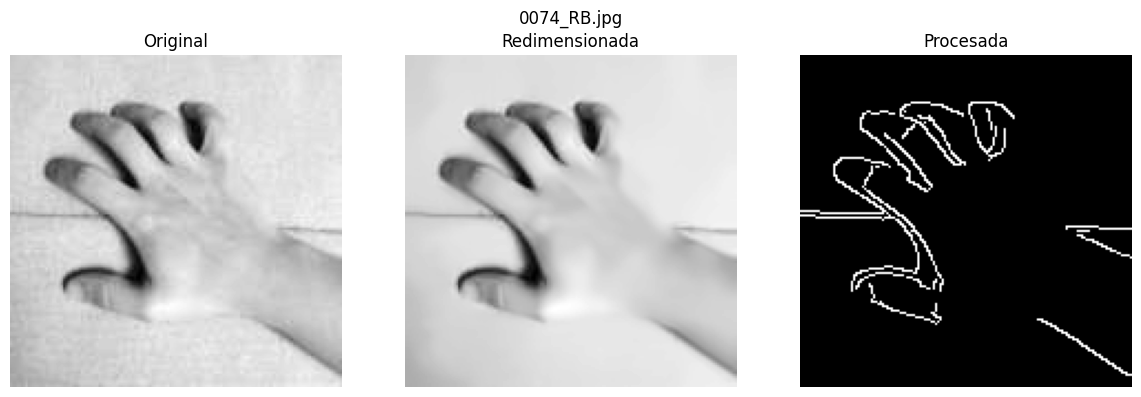

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0034_RF.jpg


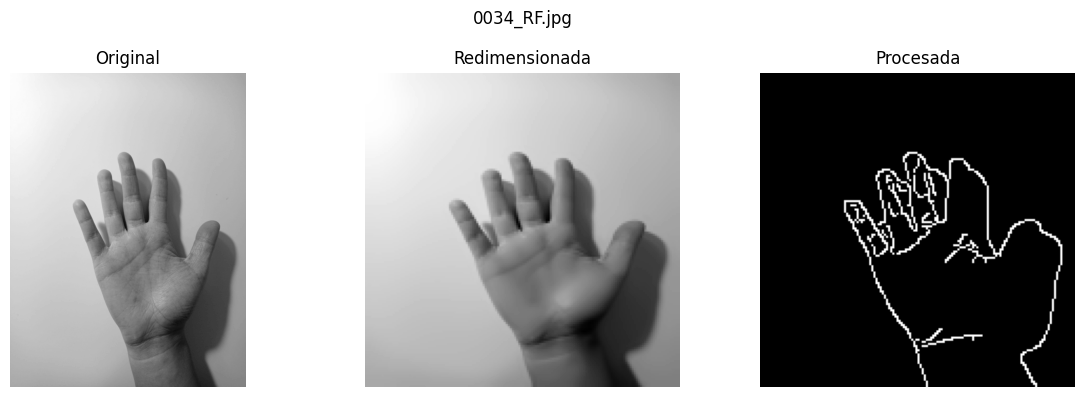

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0044_RF.jpg


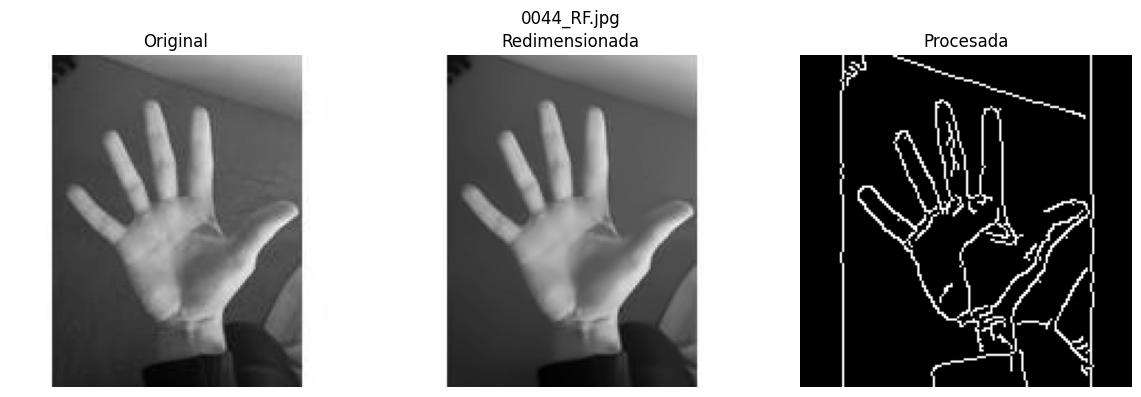

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0124_RF.jpg


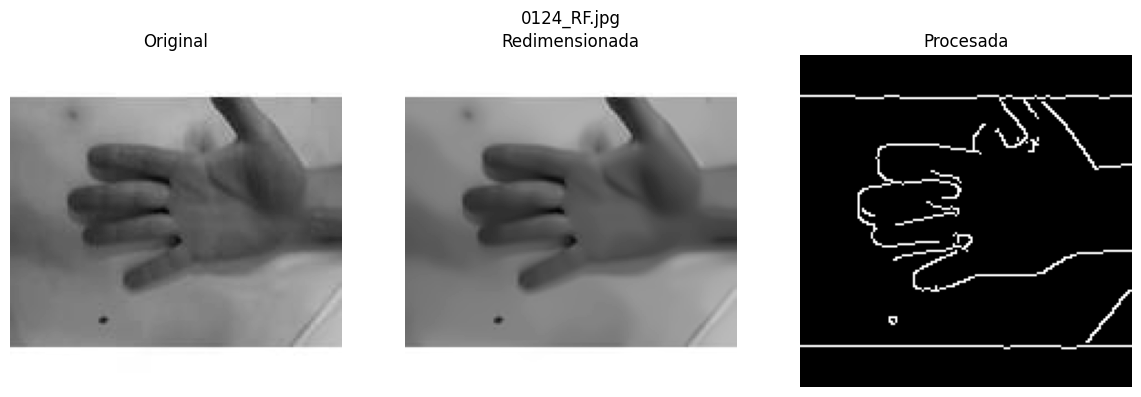

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0076_RF.jpg


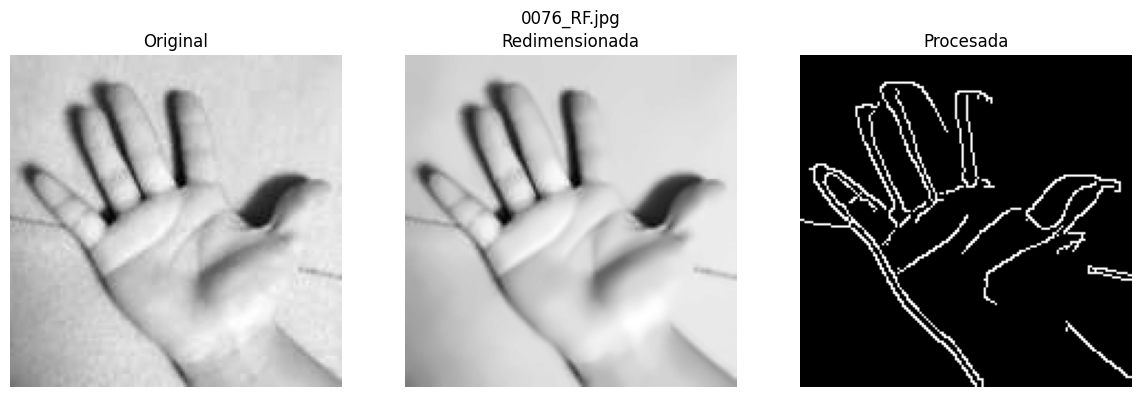

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0113_RF.jpg


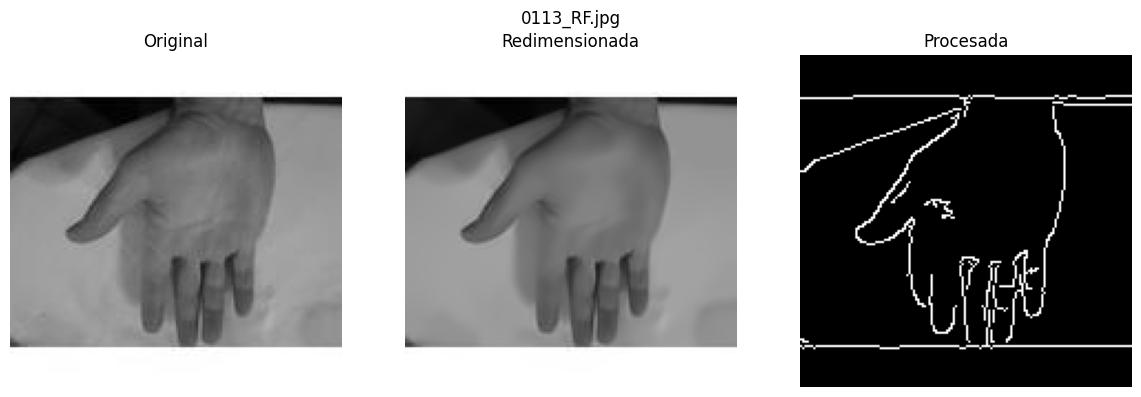

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0093_RB.jpg


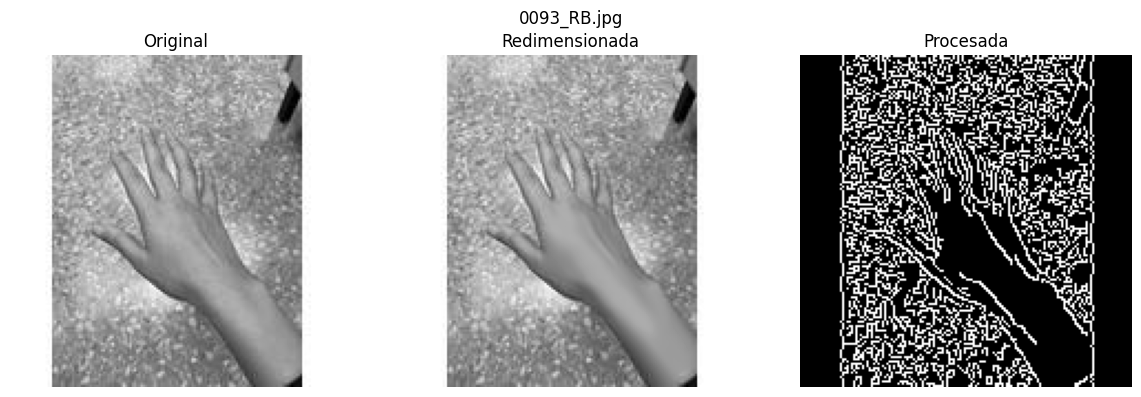

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0040_LF.jpg


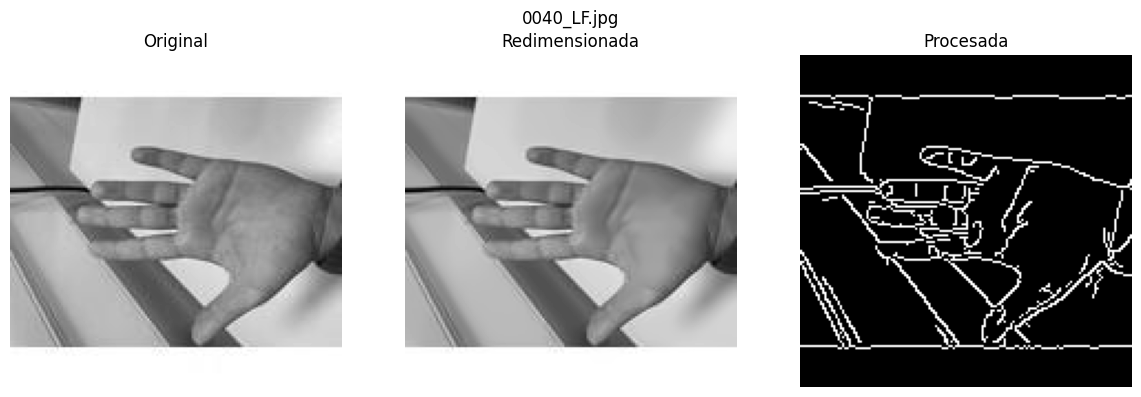

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0047_RB.jpg


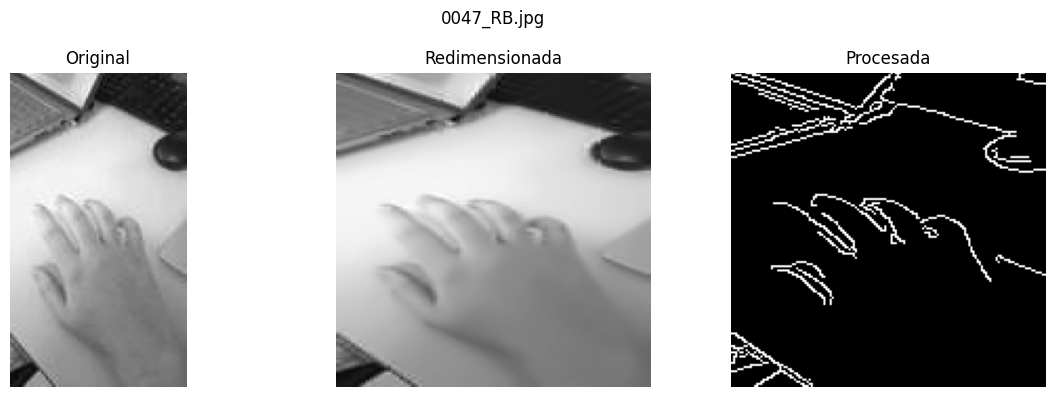

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0150_RF.jpg


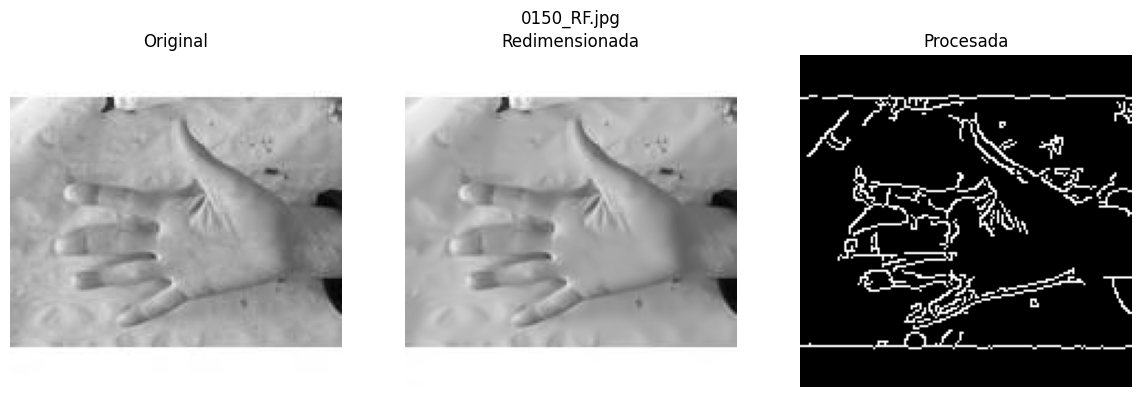

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0169_RF.jpg


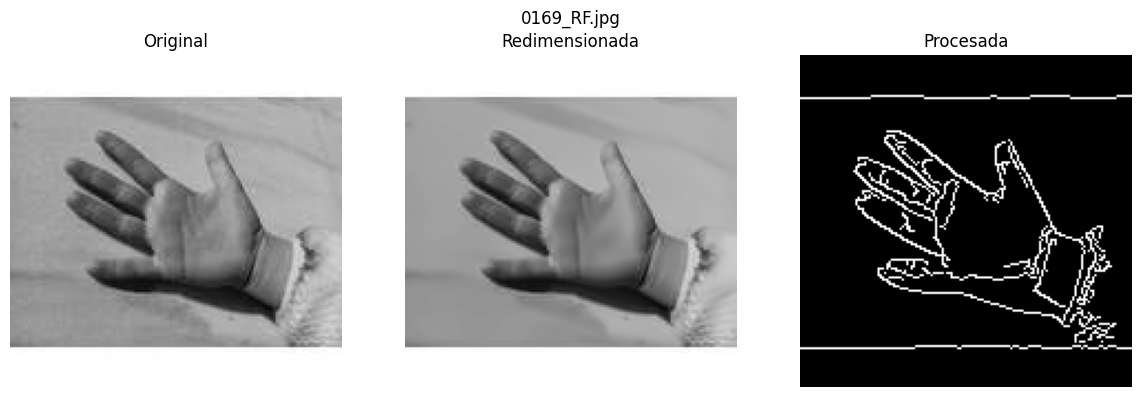

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0105_LB.jpg


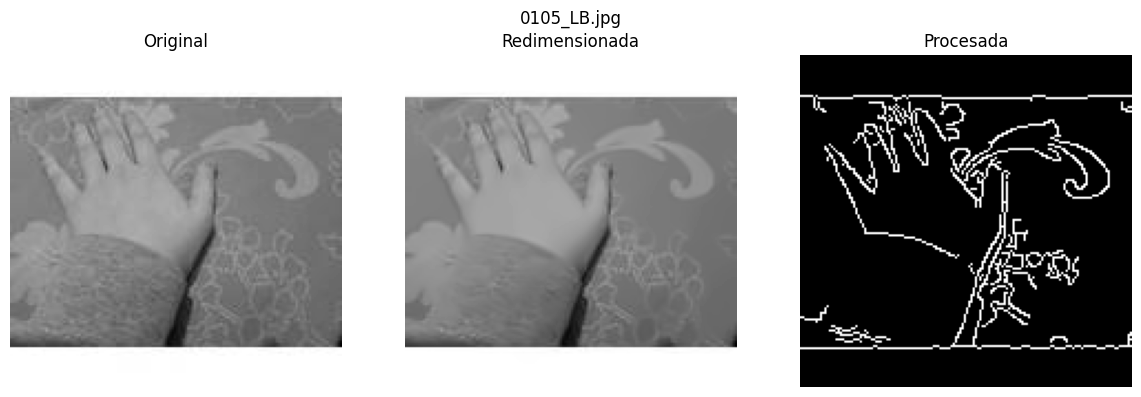

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0003_LF.jpg


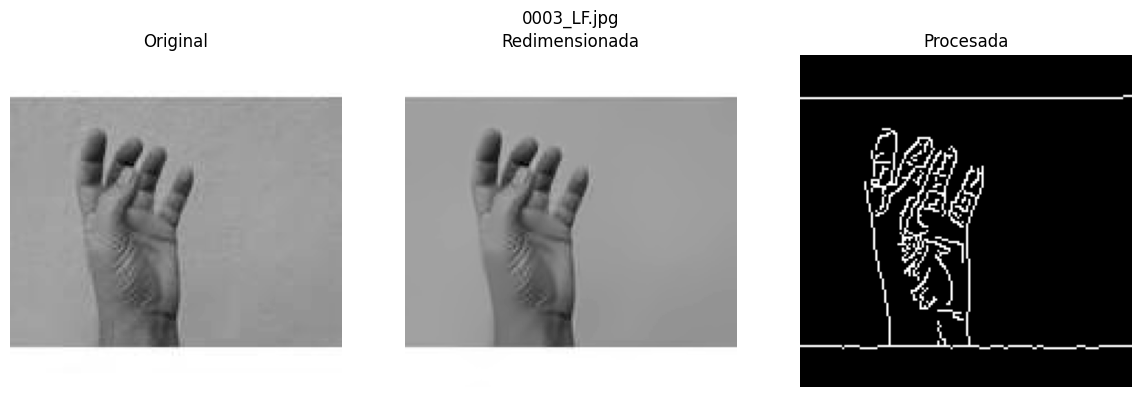

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0043_LF.jpg


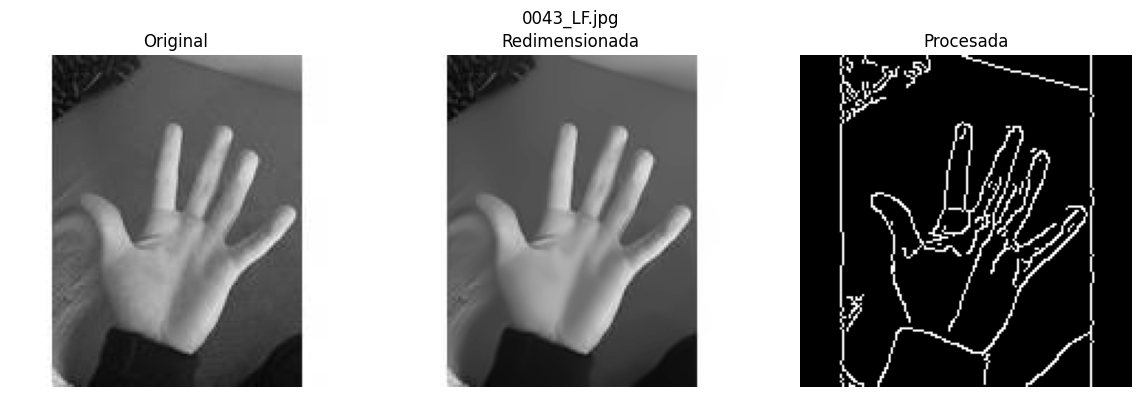

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0026_RB.jpg


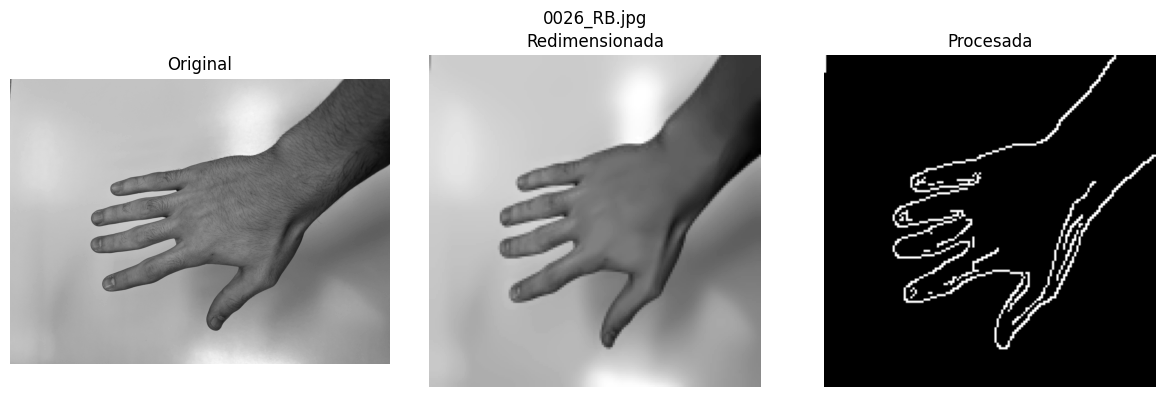

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0082_RB.jpg


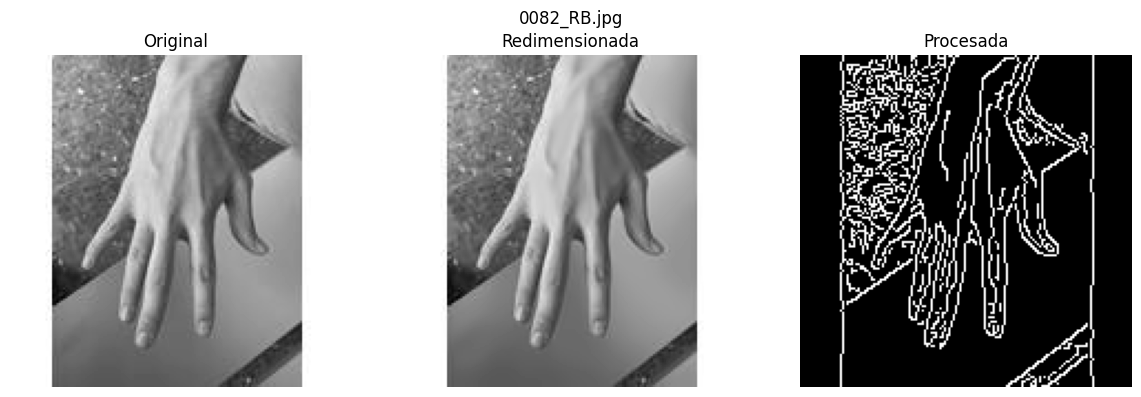

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0163_LB.jpg


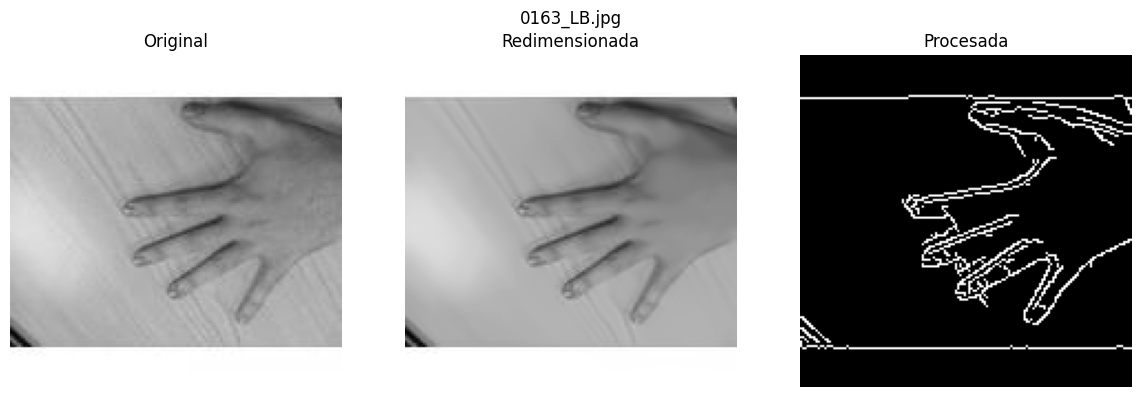

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0119_LB.jpg


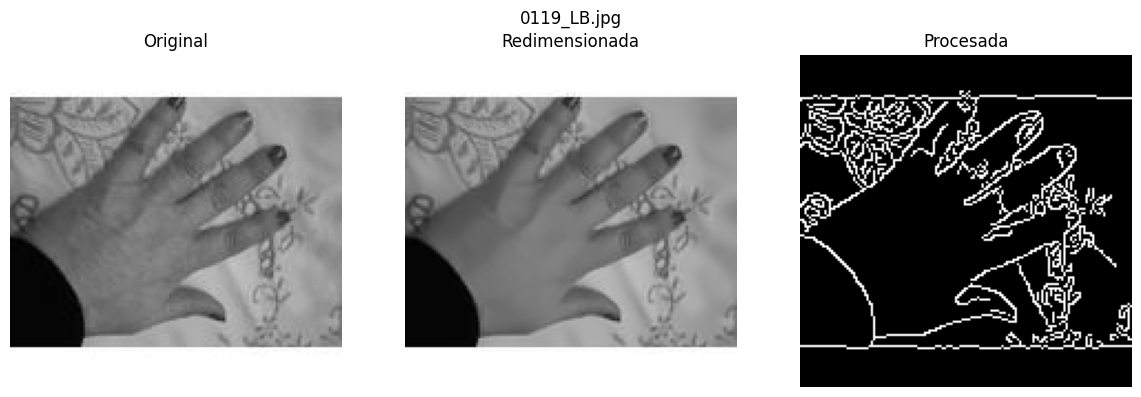

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0011_LF.jpg


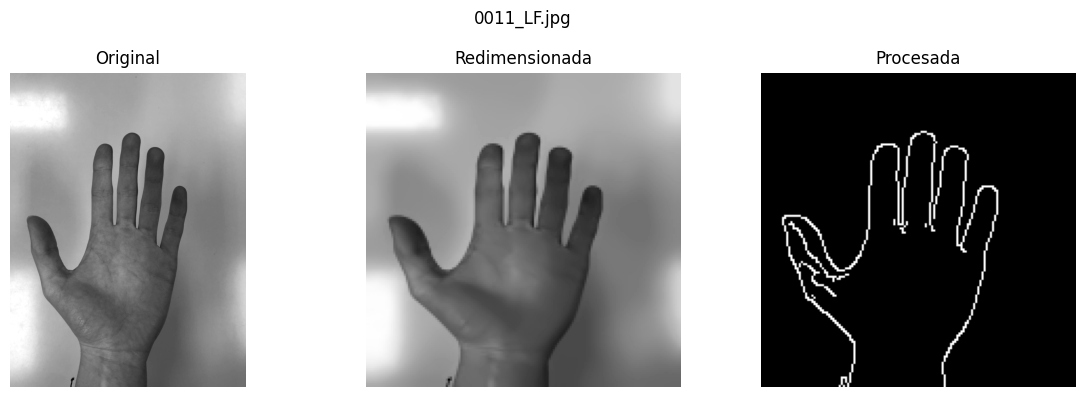

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0055_LF.jpg


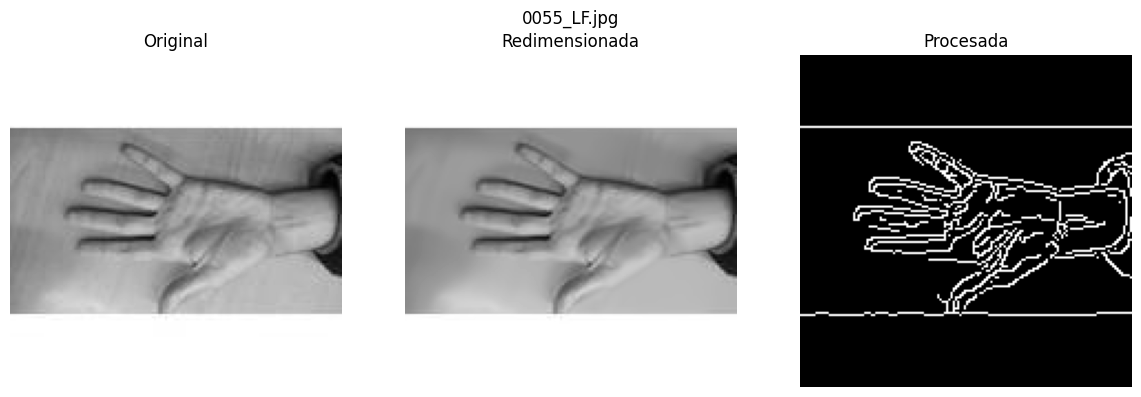

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0190_RB.jpg


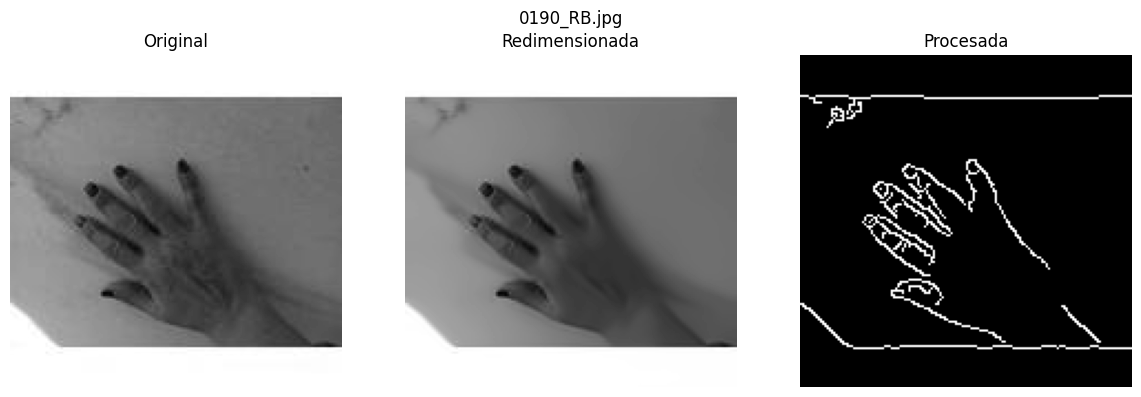

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0089_RB.jpg


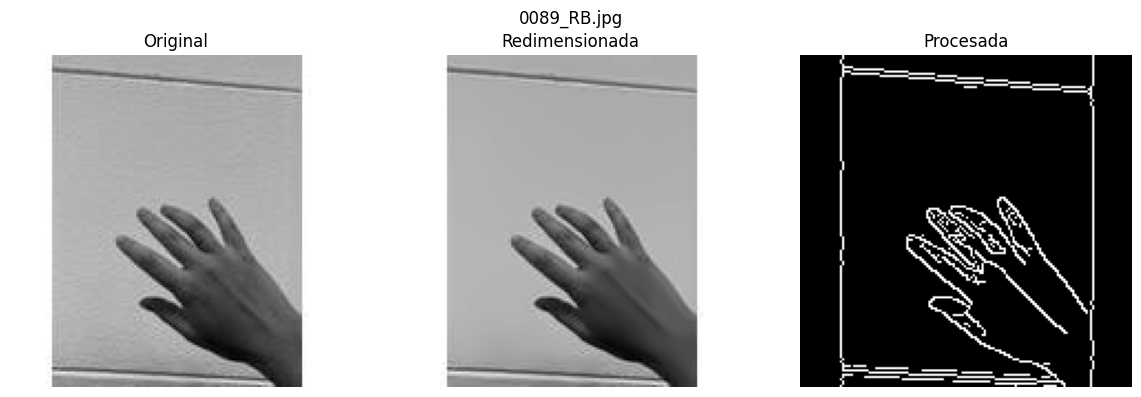

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0187_RB.jpg


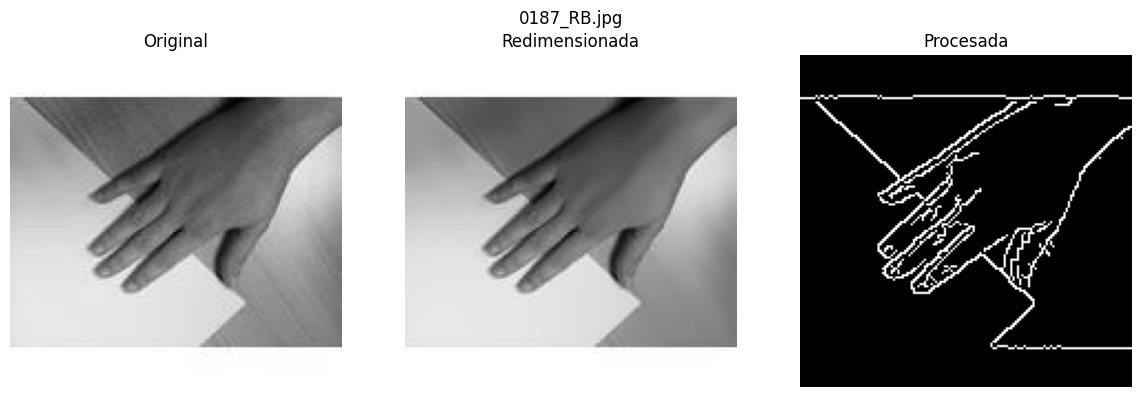

Imagen procesada guardada en: /home/pablo/Desktop/tercero/mdp/trabajo/hand_processed/0116_LB.jpg


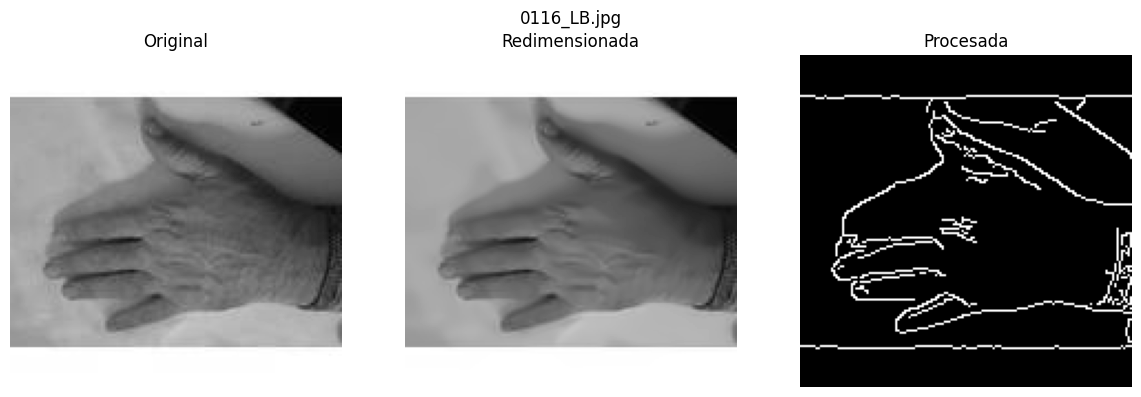

In [6]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def preprocess_hand_images(input_dir, output_dir, target_size=(150, 150), count = 0):
    """
    Procesa imágenes de manos, escalándolas a una resolución uniforme y destacando las formas.
    Muestra un gráfico de antes y después para cada imagen procesada.
    
    Args:
        input_dir (str): Directorio donde se encuentran las imágenes originales.
        output_dir (str): Directorio donde se guardarán las imágenes procesadas.
        target_size (tuple): Resolución a la que se escalarán las imágenes (ancho, alto).
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for img_name in os.listdir(input_dir):
        # Leer la imagen en escala de grises
        img_path = os.path.join(input_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"Error leyendo la imagen: {img_name}")
            continue
        
        # Escalar la imagen al tamaño objetivo
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        
        # Aplicar desenfoque para reducir ruido
        blurred_img = cv2.GaussianBlur(resized_img, (1, 1), 0)
        
        denoised = reduce_noise_non_local_means(blurred_img)
        edges = cv2.Canny(denoised, 50, 150)
        


        # Guardar la imagen procesada
        output_path = os.path.join(output_dir, img_name)
        cv2.imwrite(output_path, edges)
        print(f"Imagen procesada guardada en: {output_path}")
        
        # Mostrar antes y después
        plot_comparison(img, denoised, edges, img_name)
        count += 1
        if count > 25:
            break

def plot_comparison(original, resized, processed, title):
    """
    Muestra un gráfico comparativo del antes y después del procesamiento de una imagen.
    
    Args:
        original (numpy.ndarray): Imagen original.
        resized (numpy.ndarray): Imagen redimensionada.
        processed (numpy.ndarray): Imagen procesada.
        title (str): Nombre de la imagen.
    """
    plt.figure(figsize=(12, 4))
    
    # Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")
    plt.axis("off")
    
    # Imagen redimensionada
    plt.subplot(1, 3, 2)
    plt.imshow(resized, cmap='gray')
    plt.title("Redimensionada")
    plt.axis("off")
    
    # Imagen procesada
    plt.subplot(1, 3, 3)
    plt.imshow(processed, cmap='gray')
    plt.title("Procesada")
    plt.axis("off")
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

input_dir = '/home/pablo/Desktop/tercero/mdp/trabajo/HANDS'
output_dir = '/home/pablo/Desktop/tercero/mdp/trabajo/hand_processed'
preprocess_hand_images(input_dir, output_dir, target_size=(150, 150))


## Probando con patches extraídos homogéneamente

In [6]:
def extract_centric_patches(img, patch_size, num_patches, seed=42):
    """
    Extrae patches céntricos de una imagen de resolución 150x150.
    Los patches se seleccionan prioritariamente desde posiciones más cercanas al centro.

    Args:
        img (np.ndarray): Imagen de entrada (150x150, escala de grises).
        patch_size (int): Tamaño de los patches (cuadrados de patch_size x patch_size).
        num_patches (int): Número de patches a extraer.
        seed (int): Semilla para garantizar reproducibilidad.

    Returns:
        patches (np.ndarray): Array con los patches extraídos (num_patches, patch_size, patch_size).
        positions (list): Lista de posiciones de inicio de los patches [(row, col), ...].
    """
    assert img.shape == (150, 150), "La imagen debe tener resolución 150x150."
    assert patch_size > 0, "El tamaño del patch debe ser mayor que 0."
    assert patch_size * num_patches <= 150 * 150, "Demasiados patches para esta resolución."
    
    # Calcular la cuadrícula de celdas no superpuestas
    grid_rows = 150 // patch_size
    grid_cols = 150 // patch_size
    total_cells = grid_rows * grid_cols

    assert num_patches <= total_cells, "Demasiados patches para el tamaño del patch y la resolución de la imagen."
    
    # Generar las posiciones de la cuadrícula
    all_positions = [(i * patch_size, j * patch_size) for i in range(grid_rows) for j in range(grid_cols)]

    # Calcular las distancias de las celdas al centro de la imagen
    center = (150 // 2, 150 // 2)
    distances = [
        np.sqrt((row + patch_size // 2 - center[0])**2 + (col + patch_size // 2 - center[1])**2)
        for row, col in all_positions
    ]

    # Ordenar las posiciones por cercanía al centro
    sorted_positions = [pos for _, pos in sorted(zip(distances, all_positions))]
    
    # Seleccionar los patches más céntricos
    np.random.seed(seed)
    selected_positions = sorted_positions[:num_patches]
    
    # Extraer los patches en las posiciones seleccionadas
    patches = [img[row:row + patch_size, col:col + patch_size] for row, col in selected_positions]
    
    return np.array(patches), selected_positions


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def extract_disjoint_patches(img, patch_size, num_patches, seed=42):
    """
    Extrae patches disjuntos de una imagen de resolución 150x150.
    Los patches no se solapan entre sí.

    Args:
        img (np.ndarray): Imagen de entrada (150x150, escala de grises).
        patch_size (int): Tamaño de los patches (cuadrados de patch_size x patch_size).
        num_patches (int): Número de patches a extraer.
        seed (int): Semilla para garantizar reproducibilidad.

    Returns:
        patches (np.ndarray): Array con los patches extraídos (num_patches, patch_size, patch_size).
        positions (list): Lista de posiciones de inicio de los patches [(row, col), ...].
    """
    assert img.shape == (150, 150), "La imagen debe tener resolución 150x150."
    assert patch_size > 0, "El tamaño del patch debe ser mayor que 0."
    assert patch_size * num_patches <= 150 * 150, "Demasiados patches para esta resolución."
    
    # Dividir la imagen en una cuadrícula
    grid_rows = 150 // patch_size
    grid_cols = 150 // patch_size
    total_cells = grid_rows * grid_cols

    # Asegurarse de que no pedimos más patches de los que caben en la cuadrícula
    assert num_patches <= total_cells, "Demasiados patches para el tamaño del patch y la resolución de la imagen."

    # Generar las posiciones de la cuadrícula
    np.random.seed(seed)
    all_positions = [(i * patch_size, j * patch_size) for i in range(grid_rows) for j in range(grid_cols)]
    selected_positions = np.random.choice(len(all_positions), size=num_patches, replace=False)
    positions = [all_positions[i] for i in selected_positions]

    # Extraer los patches en las posiciones seleccionadas
    patches = [img[row:row + patch_size, col:col + patch_size] for row, col in positions]
    
    return np.array(patches), positions


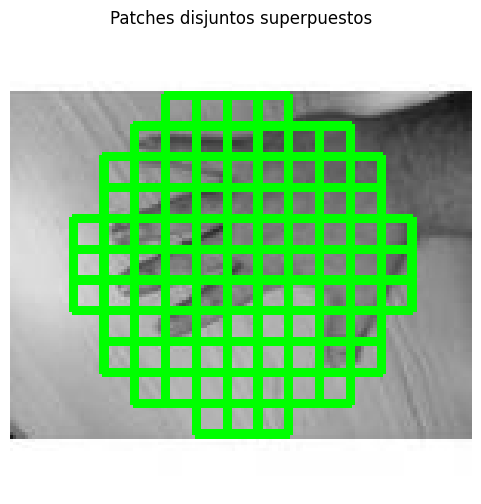

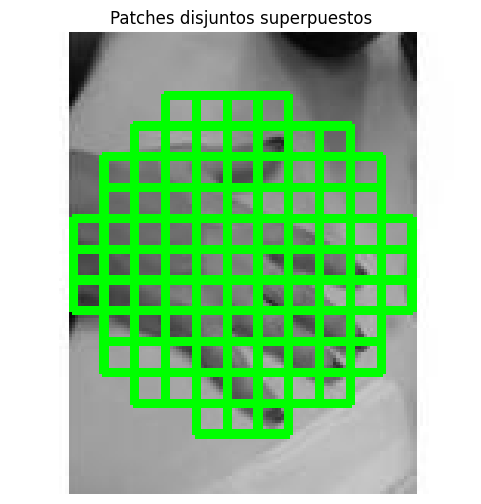

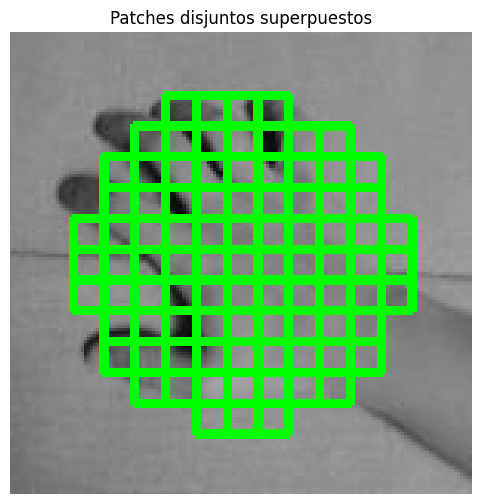

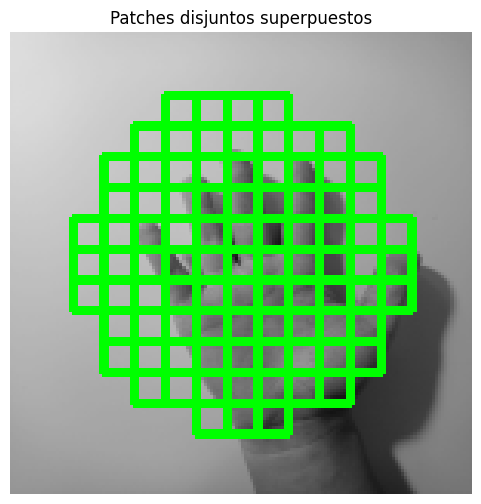

In [50]:
def visualize_disjoint_patches(img, patches, positions, patch_size):
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    for row, col in positions:
        top_left = (col, row)
        bottom_right = (col + patch_size, row + patch_size)
        cv2.rectangle(img_color, top_left, bottom_right, (0, 255, 0), 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_color[..., ::-1])  # Convertir BGR a RGB
    plt.title("Patches disjuntos superpuestos")
    plt.axis("off")
    plt.show()

    
if __name__ == "__main__":

    # Extraer patches disjuntos
    patch_size = 10
    num_patches = 90
    input_dir = '/home/pablo/Desktop/tercero/mdp/trabajo/HANDS'

    cont = 0
    for img_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_name)
        # Visualizar los patches sobre la imagen original
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(img, (150, 150), interpolation=cv2.INTER_AREA)
        patches, positions = extract_centric_patches(resized_img, patch_size, num_patches)
        visualize_disjoint_patches(resized_img, patches, positions, patch_size)
        cont += 1
        if cont > 3:
            break


In [11]:
patches.shape

(90, 10, 10)

Vamos a integrarlo con el preprocesado que teníamos antes

In [48]:
import cv2
import numpy as np
import os
from sklearn.feature_extraction import image
from sklearn.cluster import MiniBatchKMeans

dataset_path = '/home/pablo/Desktop/tercero/mdp/trabajo/HANDS'   # Cambiar por la carpeta en la que se encuentran las imágenes
 
jpgFiles = [fJPG for fJPG in os.listdir(dataset_path) if fJPG.endswith('.jpg')]

bufferImages = []
y = []

# Extraer 50 patches aleatorios de cada imagen
for filename in jpgFiles:
    img_path = os.path.join(dataset_path, filename)
    label = filename.split('.')[0][-2:]
    y.append(label)
    with open(img_path) as infile:
        # Obtener etiqueta
        img_label = filename[5:7] 
        # Leer imagen
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        bufferImages.append(img)
print(len(bufferImages))
print('Comprobación:', all([x in ['RB', 'RF', 'LB', 'LF'] for x in y]))

200
Comprobación: True


In [61]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPreprocessorSamePatches(BaseEstimator, TransformerMixin):
    def __init__(self, patchSize=10, nClusters = 81, max_patches=50):
        self.patchSize = patchSize
        self.nClusters = nClusters
        self.max_patches = max_patches

    def fit(self, X, y=None):
        return self
    
    def visualize_disjoint_patches(self, img, patches, positions, patch_size):
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        for row, col in positions:
            top_left = (col, row)
            bottom_right = (col + patch_size, row + patch_size)
            cv2.rectangle(img_color, top_left, bottom_right, (0, 255, 0), 2)

        plt.figure(figsize=(6, 6))
        plt.title("Patches disjuntos superpuestos")
        plt.imshow(img_color)
        plt.axis("off")
        plt.show()        
    
    def extract_centric_patches(self, img, patch_size, num_patches, seed=42):
        assert img.shape == (150, 150), "La imagen debe tener resolución 150x150."
        assert patch_size > 0, "El tamaño del patch debe ser mayor que 0."
        assert patch_size * num_patches <= 150 * 150, "Demasiados patches para esta resolución."
        
        # Calcular la cuadrícula de celdas no superpuestas
        grid_rows = 150 // patch_size
        grid_cols = 150 // patch_size
        total_cells = grid_rows * grid_cols

        assert num_patches <= total_cells, "Demasiados patches para el tamaño del patch y la resolución de la imagen."
        
        # Generar las posiciones de la cuadrícula
        all_positions = [(i * patch_size, j * patch_size) for i in range(grid_rows) for j in range(grid_cols)]

        # Calcular las distancias de las celdas al centro de la imagen
        center = (150 // 2, 150 // 2)
        distances = [
            np.sqrt((row + patch_size // 2 - center[0])**2 + (col + patch_size // 2 - center[1])**2)
            for row, col in all_positions
        ]

        # Ordenar las posiciones por cercanía al centro
        sorted_positions = [pos for _, pos in sorted(zip(distances, all_positions))]
        
        # Seleccionar los patches más céntricos
        np.random.seed(seed)
        selected_positions = sorted_positions[:num_patches]
        
        # Extraer los patches en las posiciones seleccionadas
        patches = [img[row:row + patch_size, col:col + patch_size] for row, col in selected_positions]

        #self.visualize_disjoint_patches(img, patches, selected_positions, patch_size)
        
        return np.array(patches)


    def bovw(self, images, patchSize, nClusters, maxPatches):
        bufferData = []
        for i in images:
            resized_img = cv2.resize(i, (150, 150), interpolation=cv2.INTER_AREA)
            patches = self.extract_centric_patches(resized_img, patchSize, num_patches=maxPatches, seed=27) # shape = (maxPatches,5,5,3)
            patches = np.reshape(patches, (len(patches), -1)) # shape = (maxPatches,75)
            bufferData.append(patches)
        dataIm = np.concatenate(bufferData, axis=0) # shape = (200*maxPatches,75)  n patches x 200 imágenes
        dataIm = dataIm.astype(float)
        dataIm -= np.mean(dataIm, axis=0)
        dataIm /= np.std(dataIm, axis=0)
        kmeans = MiniBatchKMeans(n_clusters=nClusters, random_state=27, verbose=False)
        kmeans.partial_fit(dataIm)

        X = np.reshape(kmeans.labels_ , (len(images),maxPatches)) # Indice de cluster de cada patch. shape = (200,maxPatches)
        return X

    def transform(self, images):
        # Aplica tu función de preprocesamiento aquí
        # Por ejemplo:
        # return your_custom_function(X, param1=self.param1)
        return self.bovw(images, self.patchSize, self.nClusters, self.max_patches)  # Devuelve los datos preprocesados


In [64]:
cp = CustomPreprocessorSamePatches()
X = cp.transform(bufferImages)
print(X[1])
X[0]

[10 10 63 14 42 63 42 42 20 63  8  8  8 10 33 38 34 42 42 42 46 42 33 69
 38 20  8 20 49 14 66 38 33  8 45 20 65 10 12 38 33 69 20 65 46 47 69 49
  8 52]


array([42, 42, 42, 10, 10,  8, 42, 66, 45, 38, 36, 10, 58, 35, 38, 14, 10,
       52, 45, 45, 74, 76,  0,  0, 58, 42, 76, 10,  1, 14, 38,  0, 10, 45,
       10,  1, 58,  7, 38, 34, 38, 27, 10,  1, 58, 20, 80, 10,  1, 20],
      dtype=int32)

Ahora ya no hay que hacer recuento de cuantos hay de cada tipo porque cada elemento es el mismo para todos.

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(bufferImages, y, test_size=0.2, shuffle=True, random_state=27)

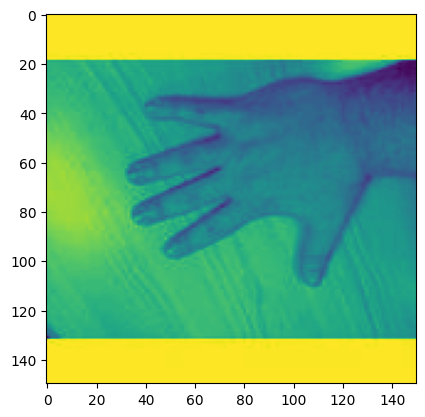

In [49]:
plt.imshow(bufferImages[0])

In [5]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Supongamos que tu vector es:
vector_categorico = np.array(['tipo1', 'tipo2', 'tipo3', 'tipo1', 'tipo2']).reshape(-1, 1)

print('Vector categórico:', vector_categorico)

# Crear un objeto OneHotEncoder
one_hot_encoder = OneHotEncoder()

# Transformar el vector categórico
vector_one_hot = one_hot_encoder.fit_transform(vector_categorico).toarray()

print("Vector One-Hot:")
print(vector_one_hot)
# Si necesitas los nombres de las categorías:
categorias = one_hot_encoder.categories_
print("Categorías:", categorias)


Vector categórico: [['tipo1']
 ['tipo2']
 ['tipo3']
 ['tipo1']
 ['tipo2']]
Vector One-Hot:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
Categorías: [array(['tipo1', 'tipo2', 'tipo3'], dtype='<U5')]
